In [0]:
!pip install bayesian-optimization
!git clone https://github.com/CSSEGISandData/COVID-19.git

In [0]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
import pandas as pd

In [0]:
df = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
rec = df[df['Country/Region']=="Greece"].values.T[4:].reshape(-1)

In [0]:
df = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
conf = df[df['Country/Region']=="Greece"].values.T[4:].reshape(-1)

Text(0, 0.5, 'Data Recovered')

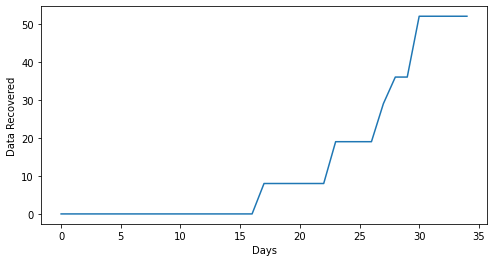

In [6]:
wg0 = np.where(conf>0)
True_rec = rec[wg0]
plt.figure(figsize=(8,4))
plt.plot(True_rec)
plt.xlabel('Days')
plt.ylabel('Data Recovered')

In [0]:
def SIR(t, sir, N, b, g):
    S, I, R = sir
    return [-b*S*I/N, b*S*I/N-g*I, g*I ]

In [0]:
D_T = True_rec.shape[0]
d_t = np.linspace(0,D_T,D_T)
std = np.std(True_rec)
mn = np.mean(True_rec)
n_data = (True_rec-mn)/std
# 'a' could be hyperparameter, 'a'>0, if 'a' == 0 then we have equal strength for all time series
a=1.5
Time_strength = np.linspace(0,1,D_T)
Time_strength = 1-np.power((1-np.power(Time_strength,a)),1/a)

In [64]:
%matplotlib inline
from ipywidgets import interactive
T = D_T+120
t = np.linspace(0, T, T)
def f(b, g,Pop):
    plt.figure(figsize=(16,8))
    sol_ep = solve_ivp(SIR, [0, T], [0.999*Pop, 0.001*Pop, b/g], args=(Pop, b, g), dense_output=True)
    ep = sol_ep.sol(t)

    plt.plot(t, ep.T[:,0], label = 'Susceptible')
    plt.plot(t, ep.T[:,1],label='Infected')
    plt.plot(t, ep.T[:,2], label='Recovered')
    plt.plot(True_rec, label='True Data')
    plt.xlabel('t')
    plt.legend(shadow=True)

    loss = (ep.T[:D_T,2]-mn)/std
    loss = (loss-n_data)*Time_strength
    loss = np.mean(np.log(np.cosh(list(loss))))

    plt.title('SIR Greece, {}'.format(loss))
    plt.ylabel('Population')
    plt.show()

interactive_plot = interactive(f, b=(0.01,1,0.0001), g=(0.01,0.1,0.00001),Pop=(1*10**3,10*10**3))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.505, description='b', max=1.0, min=0.01, step=0.0001), FloatSlider(v…

In [0]:
def black_box_function(Pop, b, g):
    sol_ep = solve_ivp(SIR, [0, D_T], [0.999*Pop, 0.001*Pop, b/g], args=(Pop, b, g), dense_output=True)
    ep = sol_ep.sol(d_t)
    
    loss = (ep.T[:,2]-mn)/std
    loss = (loss-n_data)*Time_strength
    loss = np.mean(np.log(np.cosh(list(loss))))

    return -loss

In [0]:
pbounds = {'Pop': (conf[-1], conf[-1]*10),'b':(0.1,1), 'g':(0.01,0.05)}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2
)

In [0]:
optimizer.maximize(init_points=100, n_iter=100)

In [77]:
optimizer.max

{'params': {'Pop': 6220.076349971285,
  'b': 0.12529956444297383,
  'g': 0.046028253696086624},
 'target': -0.010961890475561653}

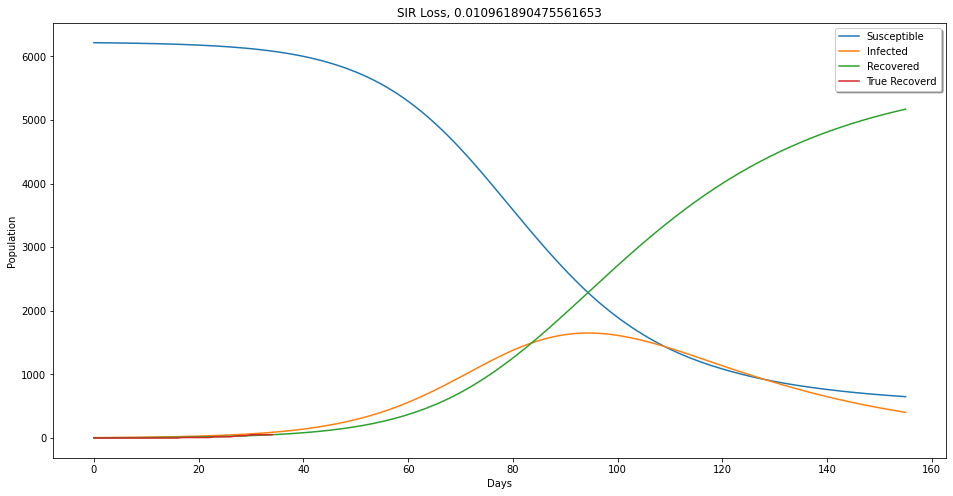

In [78]:
%matplotlib inline
from ipywidgets import interactive
T = D_T+120
t = np.linspace(0, T, T)
Pop = optimizer.max['params']['Pop']
b = optimizer.max['params']['b']
g = optimizer.max['params']['g']
loss = -optimizer.max['target']
sol_ep = solve_ivp(SIR, [0, T], [0.999*Pop, 0.001*Pop, b/g], args=(Pop, b, g), dense_output=True)
ep = sol_ep.sol(t)

plt.figure(figsize=(16,8))
plt.plot(t, ep.T[:,0], label = 'Susceptible')
plt.plot(t, ep.T[:,1],label='Infected')
plt.plot(t, ep.T[:,2], label='Recovered')
plt.plot(True_rec, label='True Recoverd')
plt.xlabel('Days')
plt.legend(shadow=True)

plt.title('SIR Loss, {}'.format(loss))
plt.ylabel('Population')
plt.show()

In [79]:
print('b', b)
print('g', g)
print('R0', b/g)
print('Pop', Pop)

b 0.12529956444297383
g 0.046028253696086624
R0 2.7222315508708284
Pop 6220.076349971285


# References
* COVID-19 Data: https://github.com/CSSEGISandData/COVID-19
* SIR model: https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology
*Bayesian Optimization: https://github.com/fmfn/BayesianOptimization